### basic

#### self-define function

In [1]:
import numpy as np

def time_me(fn):   # 用于统计函数运行时长
  def _wrapper(*args, **kwargs):
    start = time.perf_counter()
    fn(*args, **kwargs)
    print("%s cost %s second"%(fn.__name__, time.perf_counter() - start))
  return _wrapper


def sech_square(x):
    return np.multiply(1/np.cosh(x),1/np.cosh(x))

def linearInd2Binary(ind,nLabels):
    n = len(ind)
    temp = -np.ones((n,nLabels))
    for i in range(0,n):
        temp[i,ind[i,0]-1] = 1
    return temp

def standardizeCols(M,mu=None,sigma=None):
# function [S,mu,sigma2] = standardize(M, mu, sigma2)
# Make each column of M be zero mean, std 1.
# If mu, sigma2 are omitted, they are computed from M
    if type(mu)!=np.ndarray:mu=M.mean(axis=0)
    if type(sigma)!=np.ndarray:sigma=np.std(M,axis=0)
    S=(M-mu)/sigma
    return S, mu, sigma

def MLPclassificationPredict(w,X,nHidden,nLabels):
    nInstances,nVars = X.shape

    # Form Weights
    inputWeights = w[0:nVars*nHidden[0]].reshape((nVars,nHidden[0]),order='F')
    offset = nVars*nHidden[0]
    hiddenWeights=[]
    for h in range(1,len(nHidden)):
        hiddenWeights.append(w[offset:offset+nHidden[h-1]*nHidden[h]].reshape((nHidden[h-1],nHidden[h]),order='F'))
        offset = offset+nHidden[h-1]*nHidden[h]
    outputWeights = w[offset:offset+nHidden[-1]*nLabels]
    outputWeights = outputWeights.reshape((nHidden[-1],nLabels),order='F')
    ip=[]
    fp=[]
    ip.append(np.dot(np.atleast_2d(X),inputWeights))  # 进入第一个隐藏层 实例数*firstN
    fp.append(np.tanh(ip[0]))   # 激活 实例数*firstN
    for h in range(1,len(nHidden)):  
        ip.append(np.dot(fp[h-1],hiddenWeights[h-1]))    #实例数*iN
        fp.append(np.tanh(ip[h]))       #实例数*iN
    yhat = np.dot(fp[-1],outputWeights)  # 模型估计各类型概率 实例数*类型数（10）
    y=np.argmax(yhat, axis=1)
    return y

def MLPclassificationLoss(w,X,y,nHidden,nLabels):
    X=np.atleast_2d(X)
    y=np.atleast_2d(y)
    nInstances,nVars = X.shape
    # Form Weights
    inputWeights = w[0:nVars*nHidden[0]].reshape((nVars,nHidden[0]),order='F')
    offset = nVars*nHidden[0]
    hiddenWeights=[]
    for h in range(1,len(nHidden)):
        hiddenWeights.append(w[offset:offset+nHidden[h-1]*nHidden[h]].reshape((nHidden[h-1],nHidden[h]),order="F"))
        offset = offset+nHidden[h-1]*nHidden[h]
    outputWeights = w[offset:offset+nHidden[-1]*nLabels]
    outputWeights = outputWeights.reshape((nHidden[-1],nLabels),order='F')

    f = 0
    gInput = np.zeros((inputWeights.shape))
    gHidden=[]
    for h in range(1,len(nHidden)):
        gHidden.append(np.zeros((hiddenWeights[h-1].shape)))
    gOutput = np.zeros((outputWeights.shape))


    # Compute Output
    yhat=np.zeros((nInstances,outputWeights.shape[1]))
    for i in range(0,nInstances):
        ip=[]
        fp=[]

        ip.append(np.dot(np.atleast_2d(X[i,:]),inputWeights))
        fp.append(np.tanh(ip[0]))
        for h in range(1,len(nHidden)):
            ip.append(np.dot(fp[h-1],hiddenWeights[h-1]))
            fp.append(np.tanh(ip[h]))
        yhat[i,:] = np.dot(fp[-1],outputWeights)
        relativeErr = yhat-y[i,:]
        f = f + np.sum(relativeErr**2)
        err = 2*relativeErr
        # Output Weights
        for c in range(0,nLabels):
            gOutput[:,c] = gOutput[:,c]+ err[0,c]*fp[-1]

        if len(nHidden) > 1:
            # Last Layer of Hidden Weights
            backprop=np.zeros((nLabels,outputWeights.shape[0]))
            for c in range(0,nLabels):
                # print(backprop[c,:].shape,sech_square(ip[-1]).shape,outputWeights[:,c].shape)
                backprop[c,:] = err[0,c]*(np.multiply(sech_square(ip[-1]),outputWeights[:,c].T))
                gHidden[-1] = gHidden[-1] + np.dot(fp[-2].T,np.atleast_2d(backprop[c,:]))
            backprop = sum(backprop,1)

            # Other Hidden Layers
            for t in range(1,len(nHidden)-2):
                h = len(nHidden)-2-t
                backprop = np.multiply(np.dot(np.atleast_2d(backprop),hiddenWeights[h+1].T),sech_square(ip[h+1]))
                gHidden[h]  = gHidden[h]+ np.dot(fp[h].T,backprop)

            # Input Weights
            backprop = np.multiply(np.dot(np.atleast_2d(backprop),hiddenWeights[0].T),sech_square(ip[0]))
            gInput = gInput + np.dot(np.atleast_2d(X[i,:]).T,backprop)
        else:
        # Input Weights
            for c in range(0,nLabels):
                
                part1=np.atleast_2d(err[0,c]*X[i,:]).T
                part2=np.multiply(sech_square(ip[-1]),outputWeights[:,c].T)
                gInput = gInput + np.dot(part1,part2)

    # Put Gradient into vector
    g = np.zeros((w.shape))
    # 输入到第一层
    g[0:nVars*nHidden[0]] = gInput.reshape((nVars*nHidden[0],1),order='F')
    offset = nVars*nHidden[0]
    # 第一层到最后一层
    for h in range(1,len(nHidden)):
        g[offset:offset+nHidden[h-1]*nHidden[h]] = gHidden[h-1].reshape((nHidden[h-1]*nHidden[h],1),order='F')
        offset = offset+nHidden[h-1]*nHidden[h]
    # 最后一层到输出
    g[offset:offset+nHidden[-1]*nLabels] = gOutput.reshape((nHidden[-1]*nLabels,1),order='F')
    return f,g

## 向量化版的损失函数，后续改进都直接装进该函数（到task 5）
def MLPclassificationLoss_vec(w,X,y,nHidden,nLabels,Lossmethod='square'):
    X=np.atleast_2d(X)
    y=np.atleast_2d(y)
    nInstances,nVars = X.shape  # 实例个数，维度
    # Form Weights
    inputWeights = w[0:nVars*nHidden[0]].reshape((nVars,nHidden[0]),order='F')
    offset = nVars*nHidden[0]
    hiddenWeights=[]
    for h in range(1,len(nHidden)):
        hiddenWeights.append(w[offset:offset+nHidden[h-1]*nHidden[h]].reshape((nHidden[h-1],nHidden[h]),order="F"))
        offset = offset+nHidden[h-1]*nHidden[h]
    outputWeights = w[offset:offset+nHidden[-1]*nLabels]
    outputWeights = outputWeights.reshape((nHidden[-1],nLabels),order='F') # lastN*ylabelN

    gInput = np.zeros((inputWeights.shape))
    gHidden=[]
    for h in range(1,len(nHidden)):
        gHidden.append(np.zeros((hiddenWeights[h-1].shape)))
    gOutput = np.zeros((outputWeights.shape))


    # Compute Output
    yhat=np.zeros((nInstances,outputWeights.shape[1]))
    # for i in range(0,nInstances):
    ip=[]
    fp=[]

    ip.append(np.dot(np.atleast_2d(X),inputWeights))  # 进入第一个隐藏层 实例数*firstN
    fp.append(np.tanh(ip[0]))   # 激活 实例数*firstN
    for h in range(1,len(nHidden)):  
        ip.append(np.dot(fp[h-1],hiddenWeights[h-1]))    #实例数*iN
        fp.append(np.tanh(ip[h]))       #实例数*iN
    yhat = np.dot(fp[-1],outputWeights)  # 模型估计各类型概率 实例数*类型数（10）
    if Lossmethod=='square':
        relativeErr = yhat-y
        f = np.sum(relativeErr**2)
        err = np.atleast_2d(2*relativeErr)  # 实例数*类型数 概率分布与真实的误差
    if Lossmethod=='softmax':
        yhat=yhat.T
        shift_x = yhat - np.max(yhat,axis=0)
        s=np.exp(shift_x) 
        s=(s/np.sum(s,axis=0)).T  
        f = np.multiply(-np.log(s),y).sum() # 前向总误差  
        err=s
        err[y==1]-=1
        
    
    gOutput = np.dot(fp[-1].T,err)/nInstances   #  lastN*(实例数*实例数)*类型数
    err=np.atleast_2d(np.multiply(sech_square(ip[-1]),np.dot(err,outputWeights.T)))  # 实例数*lastN
    ## n个隐藏层只有n-1片权重区
    for h in range(len(nHidden)-2,-1,-1):
        # hN*实例数*实例数*(h+1)N= hN*(h+1)N
        gHidden[h]=np.dot(fp[h].T,err)/nInstances
        # 实例数*(h+1)N*(h+1)N*hN=实例数*hN
        err=np.atleast_2d(np.multiply(sech_square(ip[h]),np.dot(err,hiddenWeights[h].T))) 
    gInput= np.dot(X.T,err)/nInstances

    # Put Gradient into vector
    g = np.zeros((w.shape))
    # 输入到第一层
    g[0:nVars*nHidden[0]] = gInput.reshape((nVars*nHidden[0],1),order='F')
    offset = nVars*nHidden[0]
    # 第一层到最后一层
    for h in range(1,len(nHidden)):
        g[offset:offset+nHidden[h-1]*nHidden[h]] = gHidden[h-1].reshape((nHidden[h-1]*nHidden[h],1),order='F')
        offset = offset+nHidden[h-1]*nHidden[h]
    # 最后一层到输出
    g[offset:offset+nHidden[-1]*nLabels] = gOutput.reshape((nHidden[-1]*nLabels,1),order='F')
    return f,g


process data

In [2]:
from scipy.io import loadmat
import sys
import numpy as np
import math
import time

m = loadmat(sys.path[0]+"/digits.mat")
m2 = loadmat(sys.path[0]+"/weight1010.mat")
w=m2['w']
X=m["X"]
y=m['y']
Xvalid=m['Xvalid']
Xtest=m['Xtest']
y=m['y']
yvalid=m['yvalid']
ytest=m['ytest']
n,d=X.shape # rows and columns of matrix "X"
nLabels=y.max()  # Maximum value of vector "y"
yExpanded = linearInd2Binary(y,nLabels)
t = Xvalid.shape[0]
t2 = Xtest.shape[0]

# Standardize columns and add bias
X,mu,sigma=standardizeCols(X)
X=np.concatenate((np.ones((n,1)),X),axis=1)
d +=1 

# Make sure to apply the same transformation to the validation/test data
Xvalid,_,_ = standardizeCols(Xvalid,mu,sigma)
Xvalid = np.concatenate((np.ones((t,1)),Xvalid),axis=1)
Xtest,_,_ = standardizeCols(Xtest,mu,sigma)
Xtest = np.concatenate((np.ones((t2,1)),Xtest),axis=1)

#### baseline

In [ ]:
nHidden = [10]
    
# Count number of parameters and initialize weights 'w'
nParams = d*nHidden[0]
for h in range(1,len(nHidden)):
    nParams = nParams+nHidden[h-1]*nHidden[h]
nParams = nParams+nHidden[len(nHidden)-1]*nLabels
w = np.random.randn(nParams,1) 

# Train with stochastic gradient
maxIter = 100000
stepSize = 1e-3
for iter in range(0,maxIter): 
    
    if (iter)%round(maxIter/20) == 0:
        yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
        verr=np.sum(yhat!=(yvalid-1)[:,0])/t
        print('Training iteration = %d, validation error = %f\n'%(iter,verr))
    i = math.ceil(np.random.uniform(0, n, 1)[0])
    f,g = MLPclassificationLoss(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels)
    w = w - stepSize*g

# Evaluate test error
yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
te=np.sum(yhat!=(ytest-1)[:,0])/t2
print('Test error with final model = %f\n'%te)



## task 1 网络结构

In [17]:
def testnHidden(test):
    answer=[]
    for nHidden in test:
        # Count number of parameters and initialize weights 'w'
        nParams = d*nHidden[0]
        for h in range(1,len(nHidden)):
            nParams = nParams+nHidden[h-1]*nHidden[h]
        nParams = nParams+nHidden[len(nHidden)-1]*nLabels
        w = np.random.randn(nParams,1) 

        # Train with stochastic gradient
        maxIter = 100000
        stepSize = 1e-3
        for iter in range(0,maxIter): 
            
            if (iter)%round(maxIter/5) == 0:
                yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
                verr=np.sum(yhat!=(yvalid-1)[:,0])/t
                print('Training iteration = %d, validation error = %f\n'%(iter,verr))
            i = math.ceil(np.random.uniform(0, n, 1)[0])
            f,g = MLPclassificationLoss(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels)
            w = w - stepSize*g

        # Evaluate test error
        yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
        te=np.sum(yhat!=(ytest-1)[:,0])/t2
        print('Test error with final model = %f\n'%te)
        answer.append(te)
    return answer

result1=testnHidden([[10],[20],[50],[100],[200],[500]])
result2=testnHidden([[8,8,8,8]])


Training iteration = 0, validation error = 0.943400

Training iteration = 20000, validation error = 0.789000

Training iteration = 40000, validation error = 0.812800

Training iteration = 60000, validation error = 0.817600

Training iteration = 80000, validation error = 0.860800

Test error with final model = 0.878000



## task 2 动量

In [75]:
def momentum(nHidden=[10],momentum=0):
    answer=[]
    # Count number of parameters and initialize weights 'w'
    nParams = d*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+nHidden[h-1]*nHidden[h]
    nParams = nParams+nHidden[len(nHidden)-1]*nLabels
    w = np.random.randn(nParams,1) 

    # Train with stochastic gradient
    maxIter = 100000
    stepSize = 1e-3
    for iter in range(0,maxIter): 
        
        if (iter)%round(maxIter/5) == 0:
            yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training iteration = %d, validation error = %f'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        f,g = MLPclassificationLoss_vec(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels)
        if iter==0: w - stepSize*g
        elif iter!=0 :w = w - stepSize*g+momentum*(w-last)
        last=w

    # Evaluate test error
    yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('Test error with final model = %f\n'%te)
    answer.append(te)
    return answer

# 带动量

momentum([100],0.5)


1
Training iteration = 0, validation error = 0.902000
Training iteration = 20000, validation error = 0.271000
Training iteration = 40000, validation error = 0.254800
Training iteration = 60000, validation error = 0.242800
Training iteration = 80000, validation error = 0.260200
Test error with final model = 0.228000

2
Training iteration = 0, validation error = 0.911600
Training iteration = 20000, validation error = 0.251200
Training iteration = 40000, validation error = 0.228400
Training iteration = 60000, validation error = 0.227800
Training iteration = 80000, validation error = 0.216200
Test error with final model = 0.220000

3
Training iteration = 0, validation error = 0.917000
Training iteration = 20000, validation error = 0.237600
Training iteration = 40000, validation error = 0.229600
Training iteration = 60000, validation error = 0.240600
Training iteration = 80000, validation error = 0.241000
Test error with final model = 0.251000

4
Training iteration = 0, validation error = 0

KeyboardInterrupt: 

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pylab.rcParams['figure.figsize'] = (10.0, 5.0) # 显示大小
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

x1=[1,3,5]
y=[0.250,0.530,0.403]
n=[0.233,0.621,0.543]
y=[1-i for i in y]
n=[1-i for i in n]
unit=0.6
ysr = ['64','64,8','10,10']   #x标签
y0  = ['' for i in range(len(ysr))]       #空x标签
x2=[i+unit*1.1 for i in x1]   #bias
group_center=[i+unit/2*1.1 for i in x1]  #组中心
center_y=[0 for i in range(len(x1))]
plt.bar(x1, n, alpha=0.7, width=unit, color='r',label="raw", tick_label=y0)
plt.bar(x2, y, alpha=0.7, width=unit, color='g',label="momentum", tick_label=y0)
plt.bar(group_center,center_y,tick_label=ysr)
plt.title('带惯性与不带惯性准确率对比柱状图', fontproperties="SimSun")
plt.xlabel('nHidden')
plt.legend() # 显示图例
plt.show()

## task 3 向量化

In [25]:
from scipy.io import loadmat
import sys
import numpy as np
import math
import time

m = loadmat(sys.path[0]+"/digits.mat")
m2 = loadmat(sys.path[0]+"/weight1010.mat")
w=m2['w']
X=m["X"]
y=m['y']
Xvalid=m['Xvalid']
Xtest=m['Xtest']
y=m['y']
yvalid=m['yvalid']
ytest=m['ytest']
n,d=X.shape # rows and columns of matrix "X"
nLabels=y.max()  # Maximum value of vector "y"
yExpanded = linearInd2Binary(y,nLabels)
t = Xvalid.shape[0]
t2 = Xtest.shape[0]

# Standardize columns and add bias
X,mu,sigma=standardizeCols(X)
X=np.concatenate((np.ones((n,1)),X),axis=1)
d +=1 

# Make sure to apply the same transformation to the validation/test data
Xvalid,_,_ = standardizeCols(Xvalid,mu,sigma)
Xvalid = np.concatenate((np.ones((t,1)),Xvalid),axis=1)
Xtest,_,_ = standardizeCols(Xtest,mu,sigma)
Xtest = np.concatenate((np.ones((t2,1)),Xtest),axis=1)
@time_me
def vec(nHidden=[10],momentum=0):
    answer=[]
    # Count number of parameters and initialize weights 'w'
    nParams = d*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+nHidden[h-1]*nHidden[h]
    nParams = nParams+nHidden[len(nHidden)-1]*nLabels
    w = np.random.randn(nParams,1) 

    # Train with stochastic gradient
    maxIter = 100000
    stepSize = 1e-3
    for iter in range(0,maxIter): 
        
        if (iter)%round(maxIter/5) == 0:
            yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training iteration = %d, validation error = %f\n'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        f,g = MLPclassificationLoss_vec(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels)
        if iter!=0 :w = w - stepSize*g+momentum*(w-last)
        last=w

    # Evaluate test error
    yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('Test error with final model = %f\n'%te)
    answer.append(te)
    return answer
@time_me
def novec(nHidden=[10],momentum=0):
    answer=[]
    # Count number of parameters and initialize weights 'w'
    nParams = d*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+nHidden[h-1]*nHidden[h]
    nParams = nParams+nHidden[len(nHidden)-1]*nLabels
    w = np.random.randn(nParams,1) 

    # Train with stochastic gradient
    maxIter = 100000
    stepSize = 1e-3
    for iter in range(0,maxIter): 
        
        if (iter)%round(maxIter/5) == 0:
            yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training iteration = %d, validation error = %f\n'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        f,g = MLPclassificationLoss(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels)
        if iter!=0 :w = w - stepSize*g+momentum*(w-last)
        last=w

    # Evaluate test error
    yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('Test error with final model = %f\n'%te)
    answer.append(te)
    return answer
vec([10,10],0)
# novec([10,10],0)

#vec cost 19.61295029999974 second
#novec cost 62.16510610000114 second

Training iteration = 0, validation error = 0.841800

Training iteration = 20000, validation error = 0.654600



KeyboardInterrupt: 

## task 4 正则与早停

In [76]:
def train(nHidden=[10],momentum=0,penalty=0,maxIter = 100000):
    answer=[]
    # Count number of parameters and initialize weights 'w'
    nParams = d*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+nHidden[h-1]*nHidden[h]
    nParams = nParams+nHidden[len(nHidden)-1]*nLabels
    w = np.random.randn(nParams,1) 

    # Train with stochastic gradient
    stepSize = 1e-3
    verrList=[]
    errList=[]
    flag=0   # 用于标记早停点
    for iter in range(0,maxIter+1): 
        # 早停法
        yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
        verr=np.sum(yhat!=(yvalid-1)[:,0])/t
        verrList.append(verr)
        min_verr=min(verrList)
        if (verr-min_verr) / min_verr > 5e-2 and flag==0:
            print("\nstop at Iterations= ",iter,', validation error =',min_verr,'\n')
            flag=1
            # break
        yhat = MLPclassificationPredict(w,X,nHidden,nLabels)
        err=np.sum(yhat!=(y-1)[:,0])/t
        errList.append(err)
        if (iter)%round(maxIter/5) == 0:
            # yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            # verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training Iterations = %d, validation error = %f'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        f,g = MLPclassificationLoss_vec(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels)
        if iter!=0 :w = w - stepSize*(g+penalty*w)+momentum*(w-last)
        last=w

    # Evaluate test error
    yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('\nTest error with final model = %f\n'%te)
    answer.append(te)
    return (answer,errList,verrList)


# 早停法
_,trainErr,validErr=train([100],0,0,8000)


# Training Iterations = 0, validation error = 0.888000
# Training Iterations = 1600, validation error = 0.753600
# Training Iterations = 3200, validation error = 0.653200

# stop at Iterations  4071 , validation error = 0.6388 

# Training Iterations = 4800, validation error = 0.662000
# Training Iterations = 6400, validation error = 0.637800
# Training Iterations = 8000, validation error = 0.631000

# Test error with final model = 0.624000

Training Iterations = 0, validation error = 0.875200


KeyboardInterrupt: 

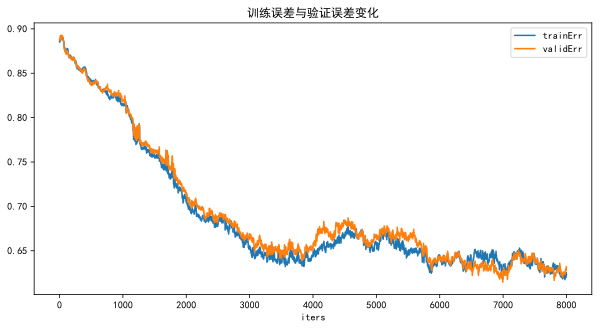

In [63]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pylab.rcParams['figure.figsize'] = (10.0, 5.0) # 显示大小
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.plot(trainErr,label='trainErr')
plt.plot(validErr,label='validErr')
plt.xlabel('iters')
plt.title('训练误差与验证误差变化')
plt.legend()
plt.show()

In [78]:
def train(nHidden=[10],momentum=0,penalty=0,maxIter = 100000,recordErr=False):
    # Count number of parameters and initialize weights 'w'
    nParams = d*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+nHidden[h-1]*nHidden[h]
    nParams = nParams+nHidden[len(nHidden)-1]*nLabels
    w = np.random.randn(nParams,1) 

    # Train with stochastic gradient
    stepSize = 1e-3
    verrList=[]
    errList=[]
    flag=0   # 用于标记早停点
    for iter in range(0,maxIter+1): 
        if recordErr:
            # 验证误差
            v_yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(v_yhat!=(yvalid-1)[:,0])/t
            verrList.append(verr)
            # 训练误差
            yhat = MLPclassificationPredict(w,X,nHidden,nLabels)
            err=np.sum(yhat!=(y-1)[:,0])/t
            errList.append(err)
        if (iter)%round(maxIter/5) == 0:
            yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training Iterations = %d, validation error = %f'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        f,g = MLPclassificationLoss_vec(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels)
        if iter!=0 :w = w - stepSize*(g+penalty*w)+momentum*(w-last)
        last=w

    # Evaluate test error
    yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('\nTest error with final model = %f\n'%te)
    testErr_final=te
    if recordErr:
        return (testErr_final,errList,verrList)
    else:
        return testErr_final

# 正则化
train([100],0.5,0.01)
# train([100],0,0,40000)

# Training Iterations = 0, validation error = 0.907600
# Training Iterations = 8000, validation error = 0.257000
# Training Iterations = 16000, validation error = 0.238200
# Training Iterations = 24000, validation error = 0.250600
# Training Iterations = 32000, validation error = 0.223000
# Training Iterations = 40000, validation error = 0.231200

# Test error with final model = 0.231000

# Training Iterations = 0, validation error = 0.897800
# Training Iterations = 8000, validation error = 0.263800
# Training Iterations = 16000, validation error = 0.240400
# Training Iterations = 24000, validation error = 0.235000
# Training Iterations = 32000, validation error = 0.242400
# Training Iterations = 40000, validation error = 0.237400

# Test error with final model = 0.246000

Training Iterations = 0, validation error = 0.906800
Training Iterations = 20000, validation error = 0.257600
Training Iterations = 40000, validation error = 0.219200
Training Iterations = 60000, validation error = 0.208000
Training Iterations = 80000, validation error = 0.201400
Training Iterations = 100000, validation error = 0.181200

Test error with final model = 0.186000



0.186

## task 5 softmax

In [8]:
def train(nHidden=[10],momentum=0,penalty=0,maxIter = 100000,recordErr=False,Lossmethod='square'):
    # Count number of parameters and initialize weights 'w'
    nParams = d*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+nHidden[h-1]*nHidden[h]
    nParams = nParams+nHidden[len(nHidden)-1]*nLabels
    w = np.random.randn(nParams,1) 

    # Train with stochastic gradient
    stepSize = 1e-3
    verrList=[]
    errList=[]
    flag=0   # 用于标记早停点
    for iter in range(0,maxIter+1): 
        if recordErr:
            # 验证误差
            v_yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(v_yhat!=(yvalid-1)[:,0])/t
            verrList.append(verr)
            # 训练误差
            yhat = MLPclassificationPredict(w,X,nHidden,nLabels)
            err=np.sum(yhat!=(y-1)[:,0])/t
            errList.append(err)
        if (iter)%round(maxIter/5) == 0:
            yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training Iterations = %d, validation error = %f'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        f,g = MLPclassificationLoss_vec(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels,Lossmethod)
        if iter==0:  w = w - stepSize*(g+penalty*w)
        if iter!=0 :w = w - stepSize*(g+penalty*w)+momentum*(w-last)
        last=w

    # Evaluate test error
    yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('\nTest error with final model = %f\n'%te)
    testErr_final=te
    if recordErr:
        return (testErr_final,errList,verrList)
    else:
        return testErr_final
    
# train([100],0.5,0.01,500000,Lossmethod='softmax')
train([100],0.5,0.01,600000)

# Training Iterations = 0, validation error = 0.899600
# Training Iterations = 40000, validation error = 0.271800
# Training Iterations = 80000, validation error = 0.180200
# Training Iterations = 120000, validation error = 0.125000
# Training Iterations = 160000, validation error = 0.091600
# Training Iterations = 200000, validation error = 0.070400
# Test error with final model = 0.068000


# Training Iterations = 0, validation error = 0.906200
# Training Iterations = 40000, validation error = 0.216800
# Training Iterations = 80000, validation error = 0.181600
# Training Iterations = 120000, validation error = 0.149800
# Training Iterations = 160000, validation error = 0.111400
# Training Iterations = 200000, validation error = 0.080000
# Test error with final model = 0.089000


Training Iterations = 0, validation error = 0.899200
Training Iterations = 80000, validation error = 0.194400
Training Iterations = 160000, validation error = 0.114000
Training Iterations = 240000, validation error = 0.060800
Training Iterations = 320000, validation error = 0.038600
Training Iterations = 400000, validation error = 0.035800

Test error with final model = 0.029000



0.029

## task 6 隐含层偏置

In [51]:
X=m["X"]
Xvalid=m['Xvalid']
Xtest=m['Xtest']
X,mu,sigma=standardizeCols(X)
Xtest,_,_ = standardizeCols(Xtest,mu,sigma)
Xvalid,_,_ = standardizeCols(Xvalid,mu,sigma)

### 修改bias的预测函数
def MLPclassificationPredict(w,X,nHidden,nLabels,bias):
    nInstances,nVars = X.shape
    # Form Weights
    inputWeights = w[0:nVars*nHidden[0]].reshape((nVars,nHidden[0]),order='F')
    inputWeights[:,0]=0
    offset = nVars*nHidden[0]
    hiddenWeights=[]
    for h in range(1,len(nHidden)):
        temp=w[offset:offset+nHidden[h-1]*nHidden[h]].reshape((nHidden[h-1],nHidden[h]),order="F")
        temp[:,0]=0
        hiddenWeights.append(temp)
        offset = offset+nHidden[h-1]*nHidden[h]
    outputWeights = w[offset:offset+nHidden[-1]*nLabels]
    outputWeights = outputWeights.reshape((nHidden[-1],nLabels),order='F') # lastN*ylabelN
    ip=[]
    fp=[]
    ip.append(np.dot(np.atleast_2d(X),inputWeights))  # 进入第一个隐藏层 实例数*firstN
    fp.append(np.tanh(ip[0]))   # 激活 实例数*firstN
    for h in range(1,len(nHidden)):  
        ip.append(np.dot(fp[h-1],hiddenWeights[h-1]))    #实例数*iN
        fp.append(np.tanh(ip[h]))       #实例数*iN
    yhat = np.dot(fp[-1],outputWeights)  # 模型估计各类型概率 实例数*类型数（10）
    y=np.argmax(yhat, axis=1)
    return y

### 修改bias的损失函数
def MLPclassificationLoss_vec_nb(w,X,y,nHidden,nLabels,bias,Lossmethod='square'):
    X=np.atleast_2d(X)
    y=np.atleast_2d(y)
    nInstances,nVars = X.shape  # 实例个数，维度
    # Form Weights
    inputWeights = w[0:nVars*nHidden[0]].reshape((nVars,nHidden[0]),order='F')
    inputWeights[:,0]=0
    offset = nVars*nHidden[0]
    hiddenWeights=[]
    for h in range(1,len(nHidden)):
        temp=w[offset:offset+nHidden[h-1]*nHidden[h]].reshape((nHidden[h-1],nHidden[h]),order="F")
        temp[:,0]=0
        hiddenWeights.append(temp)
        offset = offset+nHidden[h-1]*nHidden[h]
    outputWeights = w[offset:offset+nHidden[-1]*nLabels]
    outputWeights = outputWeights.reshape((nHidden[-1],nLabels),order='F') # lastN*ylabelN
    # 初始化
    gInput = np.zeros((inputWeights.shape))
    gHidden=[]
    for h in range(1,len(nHidden)):
        gHidden.append(np.zeros((hiddenWeights[h-1].shape)))
    gOutput = np.zeros((outputWeights.shape))

    # Compute Output
    yhat=np.zeros((nInstances,outputWeights.shape[1]))
    # for i in range(0,nInstances):
    ip=[]
    fp=[]
    temp=np.dot(np.atleast_2d(X),inputWeights)
    temp[:,0]=bias[0]
    ip.append(temp)  # 进入第一个隐藏层 实例数*firstN
    fp.append(np.tanh(ip[0]))   # 激活 实例数*firstN
    for h in range(1,len(nHidden)):  
        temp=np.dot(fp[h-1],hiddenWeights[h-1])
        temp[:,0]=bias[h]
        ip.append(temp)    #实例数*iN
        fp.append(np.tanh(ip[h]))       #实例数*iN
    yhat = np.dot(fp[-1],outputWeights)  # 模型估计各类型概率 实例数*类型数（10）
    if Lossmethod=='square':
        relativeErr = yhat-y
        f = np.sum(relativeErr**2)
        err = np.atleast_2d(2*relativeErr)  # 实例数*类型数 概率分布与真实的误差
    if Lossmethod=='softmax':
        yhat=yhat.T
        shift_x = yhat - np.max(yhat,axis=0)
        s=np.exp(shift_x) 
        s=(s/np.sum(s,axis=0)).T  
        f = np.multiply(-np.log(s),y).sum() # 前向总误差  
        err=s
        err[y==1]-=1
        
    
    gOutput = np.dot(fp[-1].T,err)/nInstances   ##  lastN*(实例数*实例数)*类型数
    # bias[-1]-=gOutput[0,:].sum()
    err=np.atleast_2d(np.multiply(sech_square(ip[-1]),np.dot(err,outputWeights.T)))  # 实例数*lastN
    ## n个隐藏层只有n-1片权重区
    for h in range(len(nHidden)-2,-1,-1):
        # hN*实例数*实例数*(h+1)N= hN*(h+1)N
        gHidden[h]=np.dot(fp[h].T,err)/nInstances
        gHidden[h][:,0]=0
        # bias[-1]-=1e-3*gHidden[h][0,:].sum()
        ## 实例数*(h+1)N*(h+1)N*hN=实例数*hN
        err=np.atleast_2d(np.multiply(sech_square(ip[h]),np.dot(err,hiddenWeights[h].T))) 
    gInput= np.dot(X.T,err)/nInstances
    gInput[:,0]=0


    # Put Gradient into vector
    g = np.zeros((w.shape))
    # 输入到第一层
    g[0:nVars*nHidden[0]] = gInput.reshape((nVars*nHidden[0],1),order='F')
    offset = nVars*nHidden[0]
    # 第一层到最后一层
    for h in range(1,len(nHidden)):
        g[offset:offset+nHidden[h-1]*nHidden[h]] = gHidden[h-1].reshape((nHidden[h-1]*nHidden[h],1),order='F')
        offset = offset+nHidden[h-1]*nHidden[h]
    # 最后一层到输出
    g[offset:offset+nHidden[-1]*nLabels] = gOutput.reshape((nHidden[-1]*nLabels,1),order='F')
    return f,g

def new_bias(nHidden=[10],momentum=0,penalty=0,maxIter =100000,bias=[0],recordErr=False,Lossmethod='square'):
    # Count number of parameters and initialize weights 'w'
    nHidden=[i+1 for i in nHidden]
    nParams = X.shape[1]*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+(nHidden[h-1])*nHidden[h]
    nParams = nParams+(nHidden[-1])*nLabels
    w = np.random.randn(nParams,1) 
    # Train with stochastic gradient
    stepSize = 1e-3
    verrList=[]
    errList=[]
    # b=[1 for i in nHidden]   # 各隐含层的偏置值
    b=bias
    for iter in range(0,maxIter+1): 
        if recordErr:
            if iter%10==0:
                # 验证误差
                v_yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels,b)
                verr=np.sum(v_yhat!=(yvalid-1)[:,0])/t
                verrList.append(verr)
                # 训练误差
                yhat = MLPclassificationPredict(w,X,nHidden,nLabels,b)
                err=np.sum(yhat!=(y-1)[:,0])/t
                errList.append(err)
        if (iter)%round(maxIter/5) == 0:
            yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels,b)
            verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training Iterations = %d, validation error = %f'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        f,g = MLPclassificationLoss_vec_nb(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels,b,Lossmethod)
        if iter==0:  w = w - stepSize*(g+penalty*w)
        if iter!=0 :w = w - stepSize*(g+penalty*w)+momentum*(w-last)
        last=w
    # Evaluate test error
    yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels,b)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('\nTest error with final model = %f\n'%te)
    testErr_final=te
    if recordErr:
        return (testErr_final,errList,verrList)
    else:
        return testErr_final


b1=new_bias([10],0,0,40000,[1],recordErr=True)
b0=new_bias([10],0,0,40000,[0],recordErr=True)

# Training Iterations = 0, validation error = 0.922200
# Training Iterations = 8000, validation error = 0.608800
# Training Iterations = 16000, validation error = 0.595400
# Training Iterations = 24000, validation error = 0.578600
# Training Iterations = 32000, validation error = 0.549800
# Training Iterations = 40000, validation error = 0.548800

# Test error with final model = 0.531000

# Training Iterations = 0, validation error = 0.919800
# Training Iterations = 8000, validation error = 0.577800
# Training Iterations = 16000, validation error = 0.585800
# Training Iterations = 24000, validation error = 0.560600
# Training Iterations = 32000, validation error = 0.548600

Training Iterations = 0, validation error = 0.913800
Training Iterations = 8000, validation error = 0.593200
Training Iterations = 16000, validation error = 0.582800
Training Iterations = 24000, validation error = 0.553600
Training Iterations = 32000, validation error = 0.535800
Training Iterations = 40000, validation error = 0.514200

Test error with final model = 0.511000

Training Iterations = 0, validation error = 0.890400
Training Iterations = 8000, validation error = 0.607400
Training Iterations = 16000, validation error = 0.600400
Training Iterations = 24000, validation error = 0.576600


KeyboardInterrupt: 

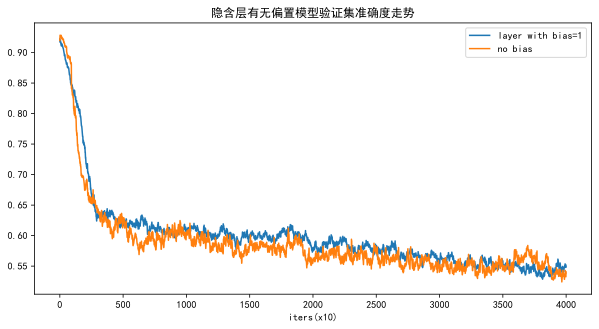

In [7]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pylab.rcParams['figure.figsize'] = (10.0, 5.0) # 显示大小
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.plot(b1[2],label='layer with bias=1')
plt.plot(b0[2],label='no bias')
plt.xlabel('iters(x10)')
plt.title('隐含层有无偏置模型验证集准确度走势')
plt.legend()
plt.show()

## task 7 dropout

In [ ]:
def MLPclassificationLoss_vec_dropout(w,X,y,nHidden,nLabels,Lossmethod='square',drop_prob=0):
    X=np.atleast_2d(X)
    y=np.atleast_2d(y)
    nInstances,nVars = X.shape  # 实例个数，维度
    #定义遮罩
    mask=[]
    p=drop_prob
    for i in nHidden:
        temp=np.random.random((i,1))
        temp[temp>p]=1
        temp[temp<=p]=0    
        mask.append(temp)

    # Form Weights
    inputWeights = w[0:nVars*nHidden[0]].reshape((nVars,nHidden[0]),order='F')
    inputWeights =np.dot(np.ones((nVars,1)),mask[0].T)*inputWeights*(1/(1-p))
    offset = nVars*nHidden[0]
    hiddenWeights=[]
    
    for h in range(1,len(nHidden)):
        temp =w[offset:offset+nHidden[h-1]*nHidden[h]].reshape((nHidden[h-1],nHidden[h]),order="F")
        temp =np.dot(mask[h-1],mask[h].T)*temp*(1/(1-p))
        hiddenWeights.append(temp)
        offset = offset+nHidden[h-1]*nHidden[h]
    outputWeights = w[offset:offset+nHidden[-1]*nLabels]
    outputWeights = outputWeights.reshape((nHidden[-1],nLabels),order='F') # lastN*ylabelN
    outputWeights=np.dot(mask[-1],np.ones((nLabels,1)).T)*outputWeights*(1/(1-p))

    gInput = np.zeros((inputWeights.shape))
    gHidden=[]
    for h in range(1,len(nHidden)):
        gHidden.append(np.zeros((hiddenWeights[h-1].shape)))
    gOutput = np.zeros((outputWeights.shape))


    # Compute Output
    yhat=np.zeros((nInstances,outputWeights.shape[1]))
    # for i in range(0,nInstances):
    ip=[]
    fp=[]

    ip.append(np.dot(np.atleast_2d(X),inputWeights))  # 进入第一个隐藏层 实例数*firstN
    fp.append(np.tanh(ip[0]))   # 激活 实例数*firstN
    for h in range(1,len(nHidden)):  
        ip.append(np.dot(fp[h-1],hiddenWeights[h-1]))    #实例数*iN
        fp.append(np.tanh(ip[h]))       #实例数*iN
    yhat = np.dot(fp[-1],outputWeights)  # 模型估计各类型概率 实例数*类型数（10）
    if Lossmethod=='square':
        relativeErr = yhat-y
        f = np.sum(relativeErr**2)
        err = np.atleast_2d(2*relativeErr)  # 实例数*类型数 概率分布与真实的误差
    if Lossmethod=='softmax':
        yhat=yhat.T
        shift_x = yhat - np.max(yhat,axis=0)
        s=np.exp(shift_x) 
        s=(s/np.sum(s,axis=0)).T  
        f = np.multiply(-np.log(s),y).sum() # 前向总误差  
        err=s
        err[y==1]-=1
        
    
    gOutput = np.dot(fp[-1].T,err)/nInstances   #  lastN*(实例数*实例数)*类型数
    gOutput = np.dot(mask[-1],np.ones((nLabels,1)).T)*gOutput*(1/(1-p))
    err=np.atleast_2d(np.multiply(sech_square(ip[-1]),np.dot(err,outputWeights.T)))  # 实例数*lastN
    ## n个隐藏层只有n-1片权重区
    for h in range(len(nHidden)-2,-1,-1):
        # hN*实例数*实例数*(h+1)N= hN*(h+1)N
        gHidden[h]=np.dot(fp[h].T,err)/nInstances
        gHidden[h]=np.dot(mask[h],mask[h+1].T)*gHidden[h]*(1/(1-p))
        # 实例数*(h+1)N*(h+1)N*hN=实例数*hN
        err=np.atleast_2d(np.multiply(sech_square(ip[h]),np.dot(err,hiddenWeights[h].T))) 
    gInput= np.dot(X.T,err)/nInstances
    gInput=np.dot(np.ones((nVars,1)),mask[0].T)*gInput*(1/(1-p))

    # Put Gradient into vector
    g = np.zeros((w.shape))
    # 输入到第一层
    g[0:nVars*nHidden[0]] = gInput.reshape((nVars*nHidden[0],1),order='F')
    offset = nVars*nHidden[0]
    # 第一层到最后一层
    for h in range(1,len(nHidden)):
        g[offset:offset+nHidden[h-1]*nHidden[h]] = gHidden[h-1].reshape((nHidden[h-1]*nHidden[h],1),order='F')
        offset = offset+nHidden[h-1]*nHidden[h]
    # 最后一层到输出
    g[offset:offset+nHidden[-1]*nLabels] = gOutput.reshape((nHidden[-1]*nLabels,1),order='F')
    return f,g



def train(nHidden=[10],momentum=0,penalty=0,maxIter = 100000,recordErr=False,Lossmethod='square',drop_p=0):
    p=drop_p
    # Count number of parameters and initialize weights 'w'
    nParams = d*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+nHidden[h-1]*nHidden[h]
    nParams = nParams+nHidden[len(nHidden)-1]*nLabels
    w = np.random.randn(nParams,1) 

    # Train with stochastic gradient
    stepSize = 1e-3
    verrList=[]
    errList=[]
    flag=0   # 用于标记早停点
    for iter in range(0,maxIter+1): 
        if recordErr:
            # 验证误差
            v_yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(v_yhat!=(yvalid-1)[:,0])/t
            verrList.append(verr)
            # 训练误差
            yhat = MLPclassificationPredict(w,X,nHidden,nLabels)
            err=np.sum(yhat!=(y-1)[:,0])/t
            errList.append(err)
        if (iter)%round(maxIter/5) == 0:
            yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training Iterations = %d, validation error = %f'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        f,g = MLPclassificationLoss_vec_dropout(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels,Lossmethod,p)
        if iter==0:  w = w - stepSize*(g+penalty*w)
        if iter!=0 :w = w - stepSize*(g+penalty*w)+momentum*(w-last)
        last=w

    # Evaluate test error
    yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('\nTest error with final model = %f\n'%te)
    testErr_final=te
    if recordErr:
        return (testErr_final,errList,verrList)
    else:
        return testErr_final
    
# train([100],0.5,0.01,200000,Lossmethod='softmax')
p0=train([10,10],0.5,0,10000,drop_p=0,recordErr=True)
p1=train([10,10],0.5,0,10000,drop_p=0.5,recordErr=True)

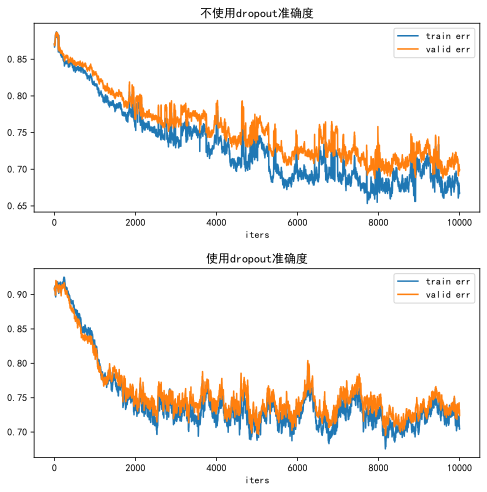

In [49]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pylab.rcParams['figure.figsize'] = (8.0, 8.0) # 显示大小
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.subplot(211)
plt.plot(p0[1],label='train err')
plt.plot(p0[2],label='valid err')
plt.xlabel('iters')
plt.title('不使用dropout准确度')
plt.legend()
plt.subplot(212)
plt.plot(p1[1],label='train err')
plt.plot(p1[2],label='valid err')
plt.xlabel('iters')
plt.title('使用dropout准确度')
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.show()

## task 8 fine-tuning

In [68]:
def fine_tuning(w,X,y,nHidden,nLabels):
    X=np.atleast_2d(X)
    y=np.atleast_2d(y)
    nInstances,nVars = X.shape  # 实例个数，维度
    # Form Weights
    inputWeights = w[0:nVars*nHidden[0]].reshape((nVars,nHidden[0]),order='F')
    offset = nVars*nHidden[0]
    hiddenWeights=[]
    for h in range(1,len(nHidden)):
        hiddenWeights.append(w[offset:offset+nHidden[h-1]*nHidden[h]].reshape((nHidden[h-1],nHidden[h]),order="F"))
        offset = offset+nHidden[h-1]*nHidden[h]
    outputWeights = w[offset:offset+nHidden[-1]*nLabels]
    outputWeights = outputWeights.reshape((nHidden[-1],nLabels),order='F') # lastN*ylabelN

    # Compute Output
    yhat=np.zeros((nInstances,outputWeights.shape[1]))
    # for i in range(0,nInstances):
    ip=[]
    fp=[]

    ip.append(np.dot(np.atleast_2d(X),inputWeights))  # 进入第一个隐藏层 实例数*firstN
    fp.append(np.tanh(ip[0]))   # 激活 实例数*firstN
    for h in range(1,len(nHidden)):  
        ip.append(np.dot(fp[h-1],hiddenWeights[h-1]))    #实例数*iN
        fp.append(np.tanh(ip[h]))       #实例数*iN
    
    #fp为每层特征值 所以fp[-1]即公式中的F
    F=fp[-1]
    temp=outputWeights
    outputWeights=np.dot(np.dot(np.linalg.inv(np.dot(F.T,F)),F.T),y)
    lr=0.05
    outputWeights=(1-lr)*temp+lr*outputWeights
    w[offset:offset+nHidden[-1]*nLabels] = outputWeights.reshape((nHidden[-1]*nLabels,1),order='F')
    return w
    


def MLPclassificationLoss_vec(w,X,y,nHidden,nLabels,Lossmethod='square',drop_prob=0):
    X=np.atleast_2d(X)
    y=np.atleast_2d(y)
    nInstances,nVars = X.shape  # 实例个数，维度
    #定义遮罩
    mask=[]
    p=drop_prob
    for i in nHidden:
        temp=np.random.random((i,1))
        temp[temp>p]=1
        temp[temp<=p]=0    
        mask.append(temp)

    # Form Weights
    inputWeights = w[0:nVars*nHidden[0]].reshape((nVars,nHidden[0]),order='F')
    inputWeights =np.dot(np.ones((nVars,1)),mask[0].T)*inputWeights*(1/(1-p))
    offset = nVars*nHidden[0]
    hiddenWeights=[]
    
    for h in range(1,len(nHidden)):
        temp =w[offset:offset+nHidden[h-1]*nHidden[h]].reshape((nHidden[h-1],nHidden[h]),order="F")
        temp =np.dot(mask[h-1],mask[h].T)*temp*(1/(1-p))
        hiddenWeights.append(temp)
        offset = offset+nHidden[h-1]*nHidden[h]
    outputWeights = w[offset:offset+nHidden[-1]*nLabels]
    outputWeights = outputWeights.reshape((nHidden[-1],nLabels),order='F') # lastN*ylabelN
    outputWeights=np.dot(mask[-1],np.ones((nLabels,1)).T)*outputWeights*(1/(1-p))

    gInput = np.zeros((inputWeights.shape))
    gHidden=[]
    for h in range(1,len(nHidden)):
        gHidden.append(np.zeros((hiddenWeights[h-1].shape)))
    gOutput = np.zeros((outputWeights.shape))


    # Compute Output
    yhat=np.zeros((nInstances,outputWeights.shape[1]))
    # for i in range(0,nInstances):
    ip=[]
    fp=[]

    ip.append(np.dot(np.atleast_2d(X),inputWeights))  # 进入第一个隐藏层 实例数*firstN
    fp.append(np.tanh(ip[0]))   # 激活 实例数*firstN
    for h in range(1,len(nHidden)):  
        ip.append(np.dot(fp[h-1],hiddenWeights[h-1]))    #实例数*iN
        fp.append(np.tanh(ip[h]))       #实例数*iN
    yhat = np.dot(fp[-1],outputWeights)  # 模型估计各类型概率 实例数*类型数（10）
    if Lossmethod=='square':
        relativeErr = yhat-y
        f = np.sum(relativeErr**2)
        err = np.atleast_2d(2*relativeErr)  # 实例数*类型数 概率分布与真实的误差
    if Lossmethod=='softmax':
        yhat=yhat.T
        shift_x = yhat - np.max(yhat,axis=0)
        s=np.exp(shift_x) 
        s=(s/np.sum(s,axis=0)).T  
        f = np.multiply(-np.log(s),y).sum() # 前向总误差  
        err=s
        err[y==1]-=1
        
    
    gOutput = np.dot(fp[-1].T,err)/nInstances   #  lastN*(实例数*实例数)*类型数
    gOutput = np.dot(mask[-1],np.ones((nLabels,1)).T)*gOutput*(1/(1-p))
    err=np.atleast_2d(np.multiply(sech_square(ip[-1]),np.dot(err,outputWeights.T)))  # 实例数*lastN
    ## n个隐藏层只有n-1片权重区
    for h in range(len(nHidden)-2,-1,-1):
        # hN*实例数*实例数*(h+1)N= hN*(h+1)N
        gHidden[h]=np.dot(fp[h].T,err)/nInstances
        gHidden[h]=np.dot(mask[h],mask[h+1].T)*gHidden[h]*(1/(1-p))
        # 实例数*(h+1)N*(h+1)N*hN=实例数*hN
        err=np.atleast_2d(np.multiply(sech_square(ip[h]),np.dot(err,hiddenWeights[h].T))) 
    gInput= np.dot(X.T,err)/nInstances
    gInput=np.dot(np.ones((nVars,1)),mask[0].T)*gInput*(1/(1-p))

    # Put Gradient into vector
    g = np.zeros((w.shape))
    # 输入到第一层
    g[0:nVars*nHidden[0]] = gInput.reshape((nVars*nHidden[0],1),order='F')
    offset = nVars*nHidden[0]
    # 第一层到最后一层
    for h in range(1,len(nHidden)):
        g[offset:offset+nHidden[h-1]*nHidden[h]] = gHidden[h-1].reshape((nHidden[h-1]*nHidden[h],1),order='F')
        offset = offset+nHidden[h-1]*nHidden[h]
    # 最后一层到输出
    g[offset:offset+nHidden[-1]*nLabels] = gOutput.reshape((nHidden[-1]*nLabels,1),order='F')
    return f,g



def train(nHidden=[10],momentum=0,penalty=0,maxIter = 100000,recordErr=False,Lossmethod='square',drop_p=0,fine_tune=False):
    p=drop_p
    # Count number of parameters and initialize weights 'w'
    nParams = d*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+nHidden[h-1]*nHidden[h]
    nParams = nParams+nHidden[len(nHidden)-1]*nLabels
    w = np.random.randn(nParams,1) 

    # Train with stochastic gradient
    stepSize = 1e-3
    verrList=[]
    errList=[]
    flag=0   # 用于标记早停点
    for iter in range(0,maxIter+1): 
        if recordErr:
            # 验证误差
            v_yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(v_yhat!=(yvalid-1)[:,0])/t
            verrList.append(verr)
            # 训练误差
            yhat = MLPclassificationPredict(w,X,nHidden,nLabels)
            err=np.sum(yhat!=(y-1)[:,0])/t
            errList.append(err)
        if (iter)%round(maxIter/5) == 0:
            yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training Iterations = %d, validation error = %f'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        f,g = MLPclassificationLoss_vec(w,X[i-1,:],yExpanded[i-1,:],nHidden,nLabels,Lossmethod,p)
        if iter==0:  w = w - stepSize*(g+penalty*w)
        if iter!=0 :w = w - stepSize*(g+penalty*w)+momentum*(w-last)
        last=w

    # Evaluate test error
    yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('\nTest error with final model = %f\n'%te)
    if fine_tune:
        w=fine_tuning(w,X,yExpanded,nHidden,nLabels)
        yhat_new = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
        te_new=np.sum(yhat_new!=(ytest-1)[:,0])/t2
        print('\nTest error with final model fine-tuned = %f\n'%te_new)
    testErr_final=te
    if recordErr:
        return (testErr_final,errList,verrList)
    else:
        return testErr_final
    
train([64,32],0.5,0.01,100000,Lossmethod='softmax',fine_tune=True)

Training Iterations = 0, validation error = 0.867600
Training Iterations = 20000, validation error = 0.493800
Training Iterations = 40000, validation error = 0.360800
Training Iterations = 60000, validation error = 0.281600
Training Iterations = 80000, validation error = 0.227800
Training Iterations = 100000, validation error = 0.183200

Test error with final model = 0.169000


Test error with final model fine-tuned = 0.168000



0.169

## task 9 人工增加样本

In [115]:
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # 显示大小
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

def rotate(image,degree,crop=False):
    image=image[1:].reshape((16,16),order='F')
    radius = math.pi * degree / 180
    width, height = image.shape
    if not crop:
        X1 = math.ceil(abs(0.5 * height * math.cos(radius) + 0.5 * width * math.sin(radius)))
        X2 = math.ceil(abs(0.5 * height * math.cos(radius) - 0.5 * width * math.sin(radius)))
        Y1 = math.ceil(abs(-0.5 * height * math.sin(radius) + 0.5 * width * math.cos(radius)))
        Y2 = math.ceil(abs(-0.5 * height * math.sin(radius) - 0.5 * width * math.cos(radius)))
        H = int(2 * max(Y1, Y2))
        W = int(2 * max(X1, X2))
        dstwidth = W + 1
        dstheight = H + 1
    if crop:
        dstheight = height
        dstwidth = width
    im_new = np.ones((dstwidth,dstheight))*image.mean()
    for i in range(dstwidth):
        for j in range(dstheight):
            new_i = int(
                (i - 0.5 * dstwidth) * math.cos(radius) - (j - 0.5 * dstheight) * math.sin(radius) + 0.5 * width)
            new_j = int(
                (i - 0.5 * dstwidth) * math.sin(radius) + (j - 0.5 * dstheight) * math.cos(radius) + 0.5 * height)
            if new_i >= 0 and new_i < width and new_j >= 0 and new_j < height:
                im_new[i,j]=image[new_i, new_j]
    # im_new.show()
    # sub = plt.subplot(1, 2, 1)
    # sub.set_title("Src Img")
    # plt.imshow(image)
    # sub = plt.subplot(1, 2, 2)
    # sub.set_title("Dst Img & Nearest")
    # plt.imshow(im_new)
    # plt.show()
    return np.r_[np.ones((1,1)),im_new.reshape((256,1),order='F')]  # 样本增加了一个bias

# img=X[0,1:]
# img2=rotate(img,20,crop=True)
# print(img2.shape)


In [120]:
def train(nHidden=[10],momentum=0,penalty=0,maxIter = 100000,recordErr=False,Lossmethod='square',rotate_p=0):
    # Count number of parameters and initialize weights 'w'
    nParams = d*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+nHidden[h-1]*nHidden[h]
    nParams = nParams+nHidden[len(nHidden)-1]*nLabels
    w = np.random.randn(nParams,1) 

    # Train with stochastic gradient
    stepSize = 1e-3
    verrList=[]
    errList=[]
    flag=0   # 用于标记早停点
    for iter in range(0,maxIter+1): 
        if recordErr:
            # 验证误差
            v_yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(v_yhat!=(yvalid-1)[:,0])/t
            verrList.append(verr)
            # 训练误差
            yhat = MLPclassificationPredict(w,X,nHidden,nLabels)
            err=np.sum(yhat!=(y-1)[:,0])/t
            errList.append(err)
        if (iter)%round(maxIter/5) == 0:
            yhat = MLPclassificationPredict(w,Xvalid,nHidden,nLabels)
            verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training Iterations = %d, validation error = %f'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        img=X[i-1,:]
        # 0.2概率旋转
        if np.random.uniform(0,1)<rotate_p: img=rotate(img,np.random.uniform(-10,10),crop=True)  
        f,g = MLPclassificationLoss_vec(w,img,yExpanded[i-1,:],nHidden,nLabels,Lossmethod)
        if iter==0:  w = w - stepSize*(g+penalty*w)
        if iter!=0 :w = w - stepSize*(g+penalty*w)+momentum*(w-last)
        last=w

    # Evaluate test error
    yhat = MLPclassificationPredict(w,Xtest,nHidden,nLabels)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('\nTest error with final model = %f\n'%te)
    testErr_final=te
    if recordErr:
        return (testErr_final,errList,verrList)
    else:
        return testErr_final
    
# train([100],0.5,0.01,200000,Lossmethod='softmax')
train([100],0.5,0.01,100000,rotate_p=0.2)
# Test error with final model = 0.169000
train([100],0.5,0.01,100000)
# Test error with final model = 0.170000

Training Iterations = 0, validation error = 0.900200
Training Iterations = 20000, validation error = 0.230600
Training Iterations = 40000, validation error = 0.205600
Training Iterations = 60000, validation error = 0.202200
Training Iterations = 80000, validation error = 0.191000
Training Iterations = 100000, validation error = 0.170400

Test error with final model = 0.169000

Training Iterations = 0, validation error = 0.904400
Training Iterations = 20000, validation error = 0.221400
Training Iterations = 40000, validation error = 0.229600
Training Iterations = 60000, validation error = 0.199600
Training Iterations = 80000, validation error = 0.192600
Training Iterations = 100000, validation error = 0.176400

Test error with final model = 0.170000



0.17

## task 10 卷积层

In [6]:
from CNN_module import CNN_predict,CNN_loss

def CNN_train(nHidden=[10],momentum=0,penalty=0,maxIter = 100000,recordErr=False,Lossmethod='square',kernel_size=5):
    # Count number of parameters and initialize weights 'w'
    nParams = kernel_size*kernel_size
    k=kernel_size
    nParams += d*nHidden[0]
    for h in range(1,len(nHidden)):
        nParams = nParams+nHidden[h-1]*nHidden[h]
    nParams = nParams+nHidden[len(nHidden)-1]*nLabels
    w = np.random.randn(nParams,1) 

    # Train with stochastic gradient
    stepSize = 1e-3
    verrList=[]
    errList=[]
    flag=0   # 用于标记早停点
    for iter in range(0,maxIter+1): 
        if recordErr:
            # 验证误差
            v_yhat = CNN_predict(w,Xvalid,k,nHidden,nLabels)
            verr=np.sum(v_yhat!=(yvalid-1)[:,0])/t
            verrList.append(verr)
            # 训练误差
            yhat = CNN_predict(w,X,k,nHidden,nLabels)
            err=np.sum(yhat!=(y-1)[:,0])/t
            errList.append(err)
        if (iter)%round(maxIter/5) == 0:
            yhat = CNN_predict(w,Xvalid,k,nHidden,nLabels)
            verr=np.sum(yhat!=(yvalid-1)[:,0])/t
            print('Training Iterations = %d, validation error = %f'%(iter,verr))
        i = math.ceil(np.random.uniform(0, n, 1)[0])
        f,g = CNN_loss(w,X[i-1,:],yExpanded[i-1,:],k,nHidden,nLabels,Lossmethod)
        if iter==0:  w = w - stepSize*(g+penalty*w)
        if iter!=0 :w = w - stepSize*(g+penalty*w)+momentum*(w-last)
        last=w

    # Evaluate test error
    yhat = CNN_predict(w,Xtest,k,nHidden,nLabels)
    te=np.sum(yhat!=(ytest-1)[:,0])/t2
    print('\nTest error with final model = %f\n'%te)
    testErr_final=te
    if recordErr:
        return (testErr_final,errList,verrList)
    else:
        return testErr_final

# CNN_train([32],0,0,100000,kernel_size=5,Lossmethod='softmax')
# Training Iterations = 0, validation error = 0.926400
# Training Iterations = 20000, validation error = 0.342000
# Training Iterations = 40000, validation error = 0.250800
# Training Iterations = 60000, validation error = 0.212200
# Training Iterations = 80000, validation error = 0.199200
# Training Iterations = 100000, validation error = 0.190800
# Test error with final model = 0.180000


train([100,32],0,0,100000,Lossmethod='softmax')
# Training Iterations = 0, validation error = 0.918000
# Training Iterations = 20000, validation error = 0.549600
# Training Iterations = 40000, validation error = 0.449400
# Training Iterations = 60000, validation error = 0.405800
# Training Iterations = 80000, validation error = 0.379800
# Training Iterations = 100000, validation error = 0.361400
# Test error with final model = 0.378000

Training Iterations = 0, validation error = 0.918000
Training Iterations = 20000, validation error = 0.549600
Training Iterations = 40000, validation error = 0.449400
Training Iterations = 60000, validation error = 0.405800
Training Iterations = 80000, validation error = 0.379800
Training Iterations = 100000, validation error = 0.361400

Test error with final model = 0.378000



0.378